In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import set_matplotlib_formats


set_matplotlib_formats('svg')
%matplotlib inline
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [12., 8.]

In [3]:
from hardnet_segm import HardNetSegm
import cv2
import torch
from bts_estimator import BTSEstimator
from plane_detector import PlaneDetector

In [4]:
model = PlaneDetector("depth_estimator/models/bts_latest", "segmnetator/hardnet70_cityscapes_model_2.pkl")

In [4]:
%%time 
import os
import seaborn as sns
from tqdm import tqdm


path = "/home/ruslan/Документы/startup/FCHarDNet/data/leftImg8bit/val/frankfurt/"
files = os.listdir(path)

images = [cv2.imread(path + item) for item in tqdm(files)]

100%|██████████| 267/267 [00:18<00:00, 14.68it/s]

CPU times: user 16.9 s, sys: 1.19 s, total: 18.1 s
Wall time: 18.4 s


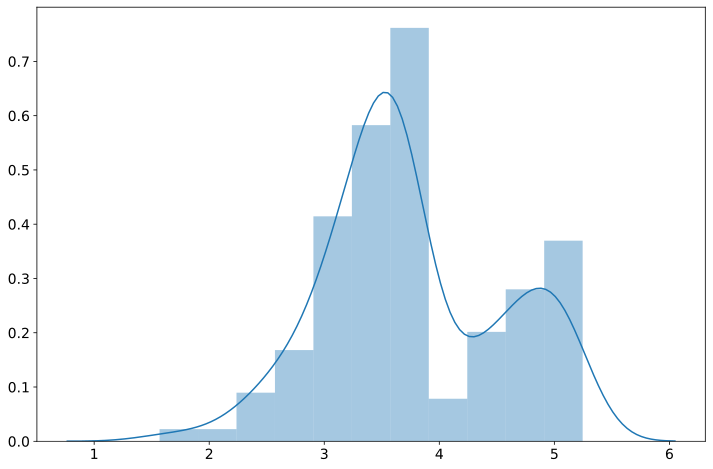

In [319]:
segm = []
for item in tqdm(images):
    _, tt = model.get_segm_map(img=item)
    segm.append(1 / tt)
sns.distplot(segm);

In [5]:
from depth_estimator.BTS import BtsController
import numpy as np

img = cv2.imread("/home/ruslan/Документы/startup/research/data/paris/54_location_48.8877725,2.3276071/280/gsv_0.jpg")
# img = cv2.imread("/home/ruslan/Загрузки/72ac1342-b976-48ad-9c20-9197707c7e62.jpeg")

seg_map, _ = model.get_segm_map(img=img)
depth_map = model.get_depth_map(img=img)
depth_img = BtsController.depth_map_to_rgbimg(depth_map)
        
vect_func = np.vectorize(lambda x: x in set([2]))
map_arr = vect_func(seg_map)

/home/ruslan/.local/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


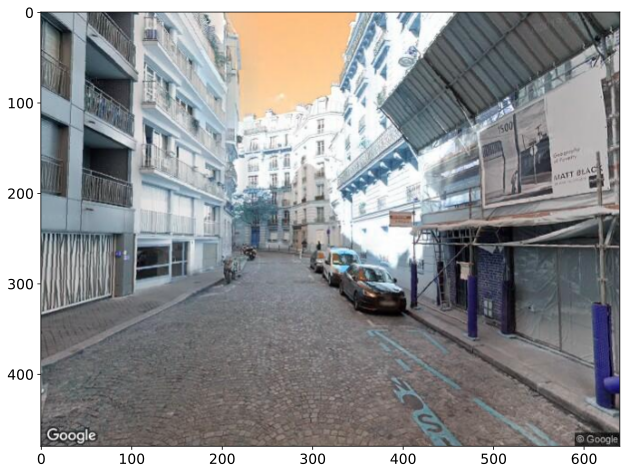

In [320]:
plt.imshow(img)

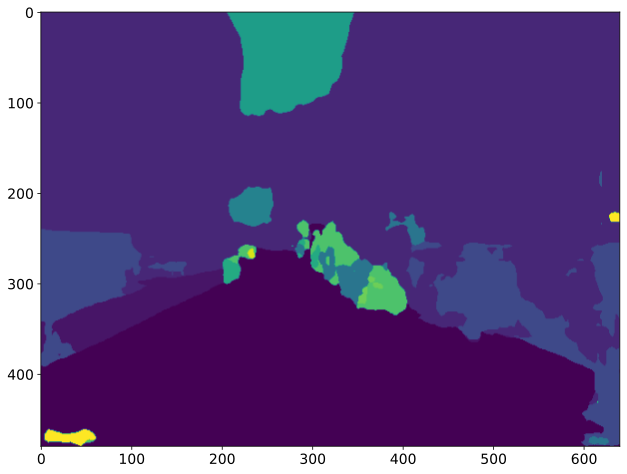

In [321]:
plt.imshow(seg_map)

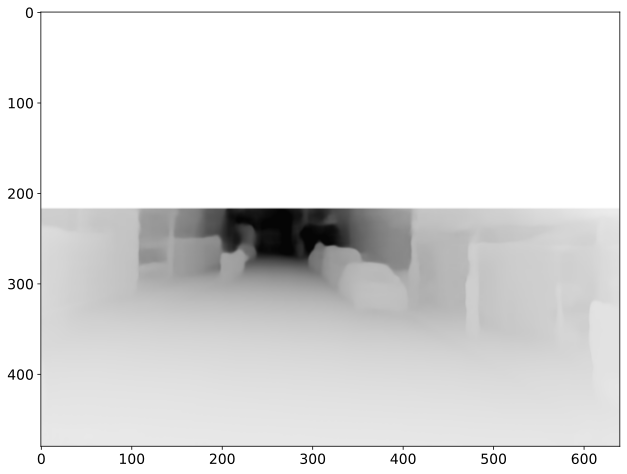

In [323]:
plt.imshow(BtsController.depth_map_to_rgbimg(depth_map))

In [307]:
%%time
from collections import Counter


Counter(list(seg_map.flatten())).most_common(7)

CPU times: user 67.2 ms, sys: 2.01 ms, total: 69.2 ms
Wall time: 68.1 ms


[(2, 165922),
 (0, 87989),
 (4, 24978),
 (10, 11946),
 (1, 6620),
 (13, 3682),
 (7, 2597)]

In [308]:
import open3d as o3d
import os
import sys

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

target = o3d.geometry.Image(np.array(depth_map * map_arr))

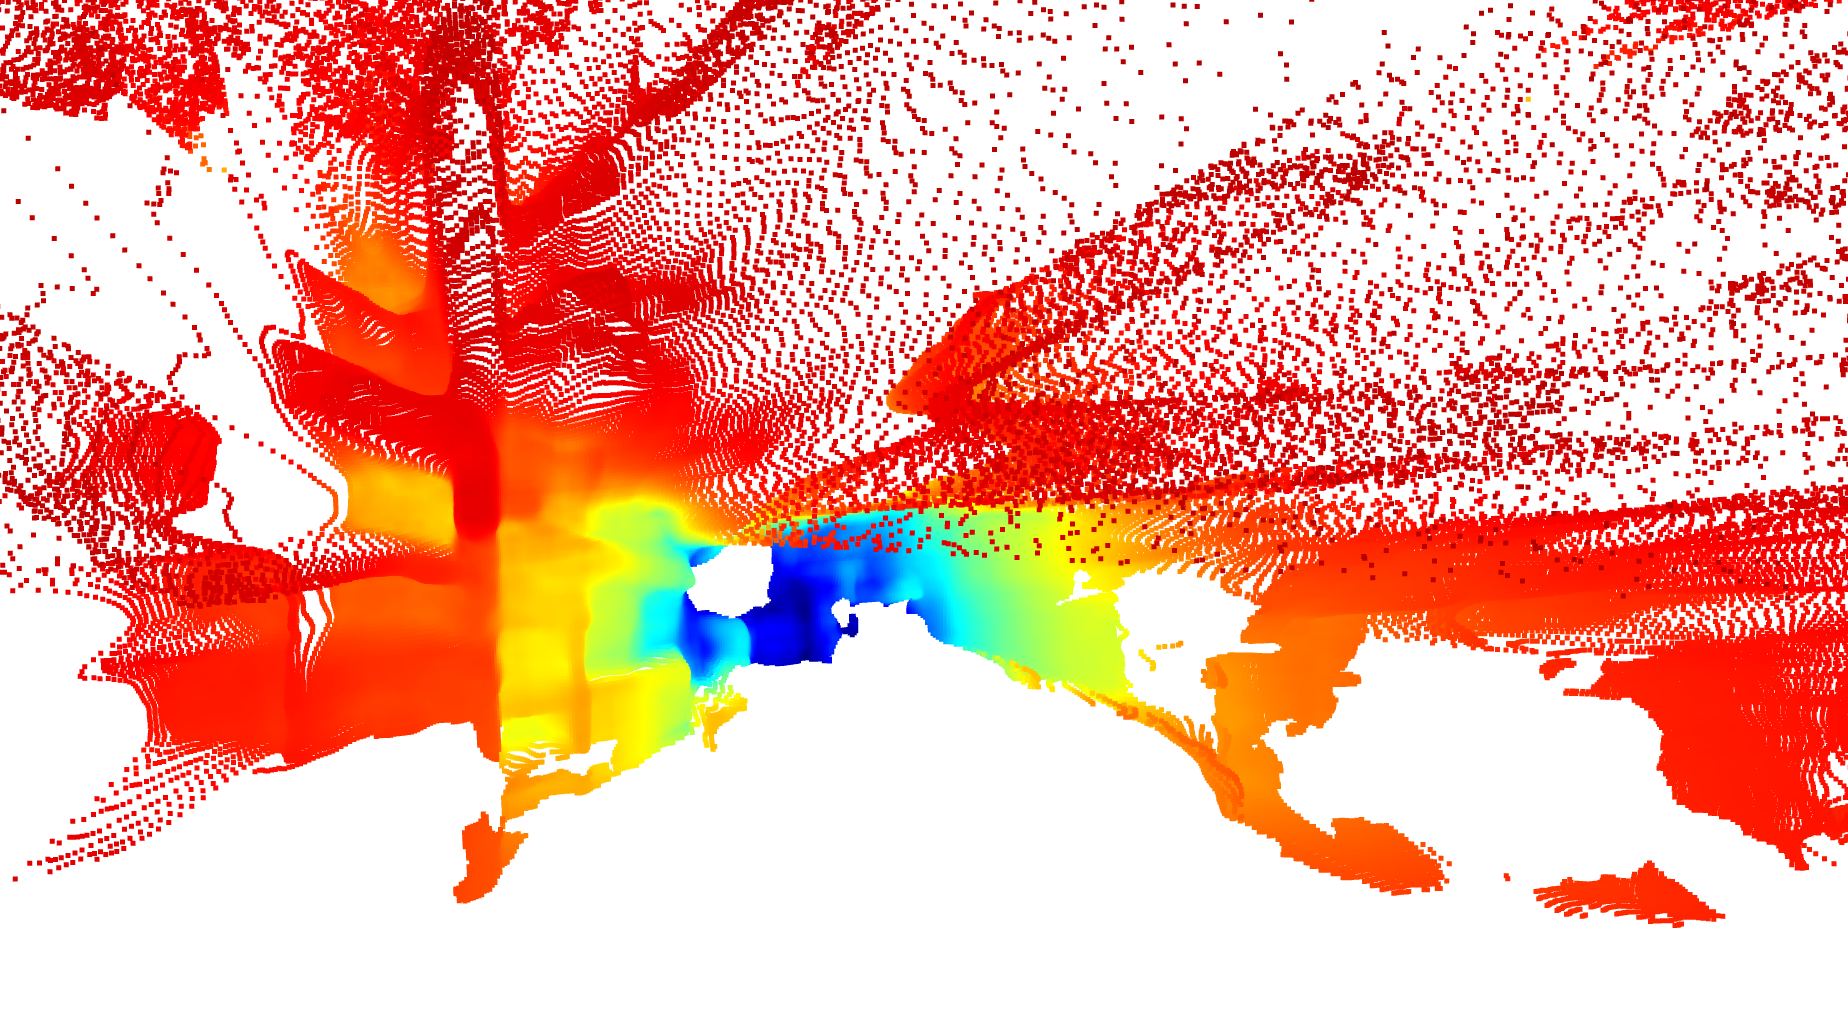

In [309]:
pcd = o3d.geometry.PointCloud.create_from_depth_image(
    target,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd], zoom=0.35)

In [310]:
from ransac_detector import *


croped_depth = crop_depth_map(depth_map, threshold=0.45)

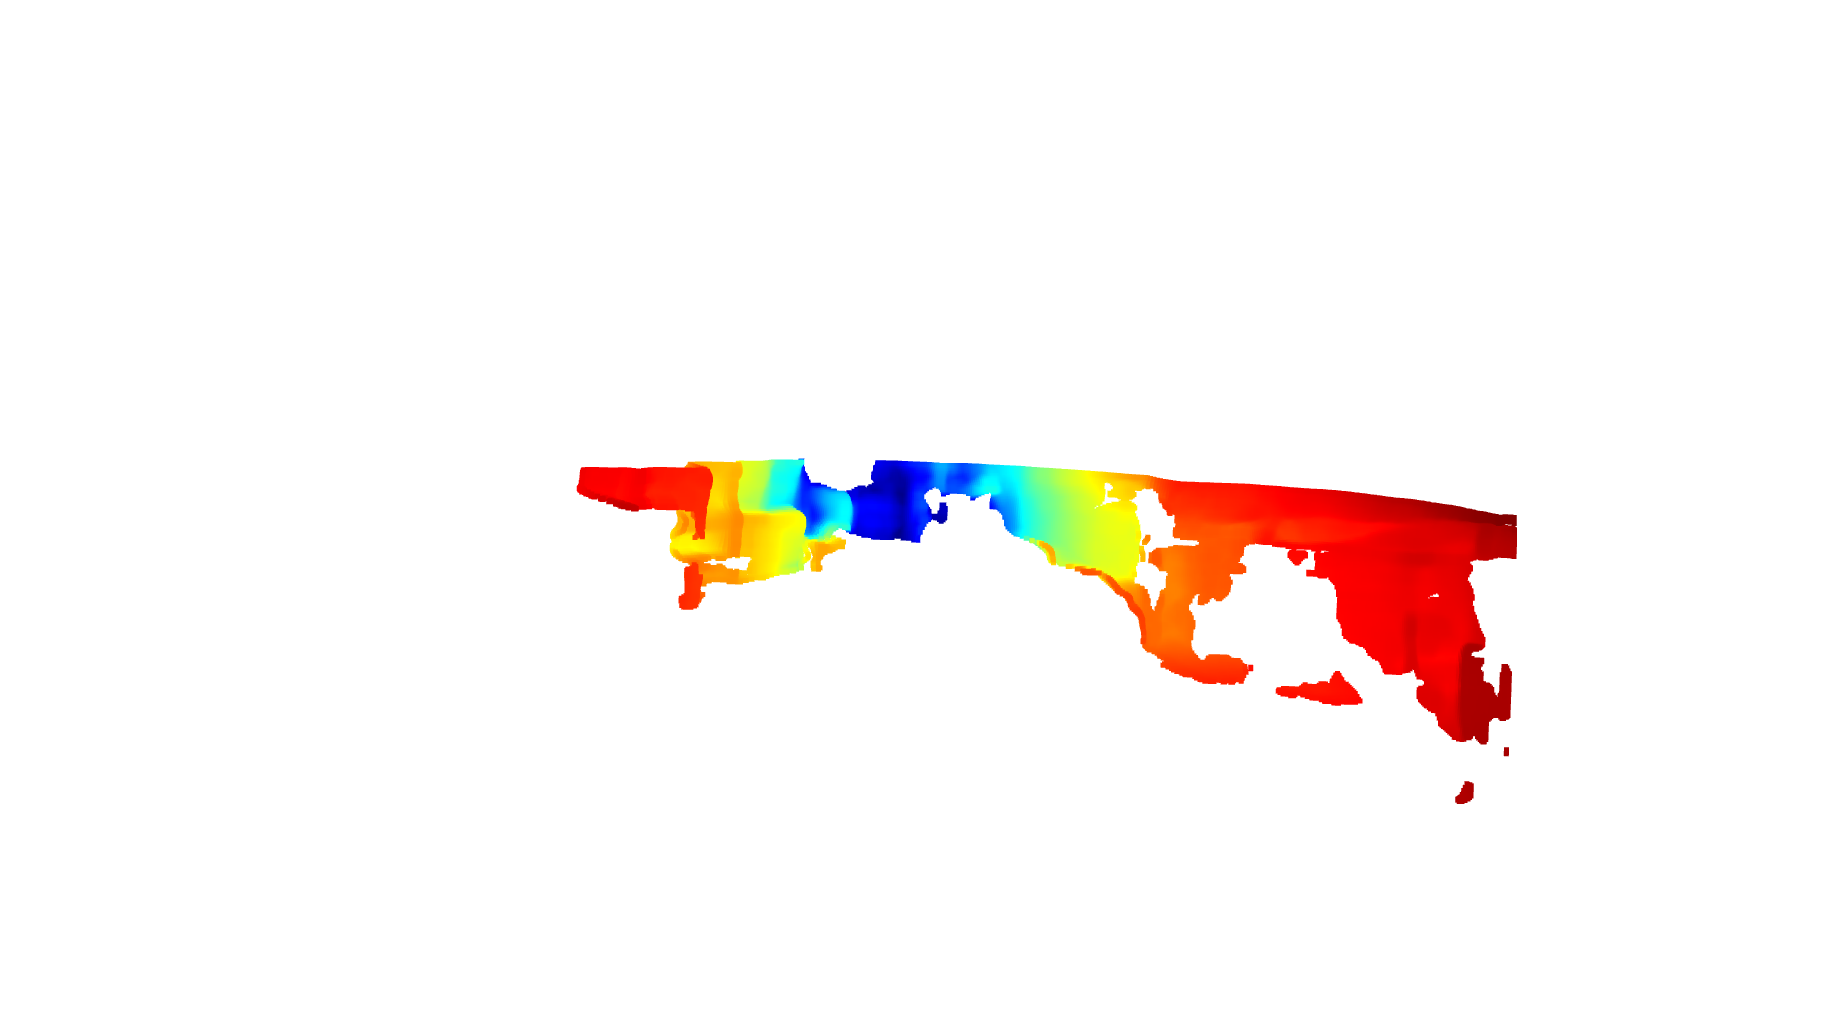

In [311]:
croped_target = o3d.geometry.Image(croped_depth * map_arr)

pcd = o3d.geometry.PointCloud.create_from_depth_image(
    croped_target,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd], zoom=0.35)

In [312]:
downsm = downsample_pcd(pcd, voxel=0.2)

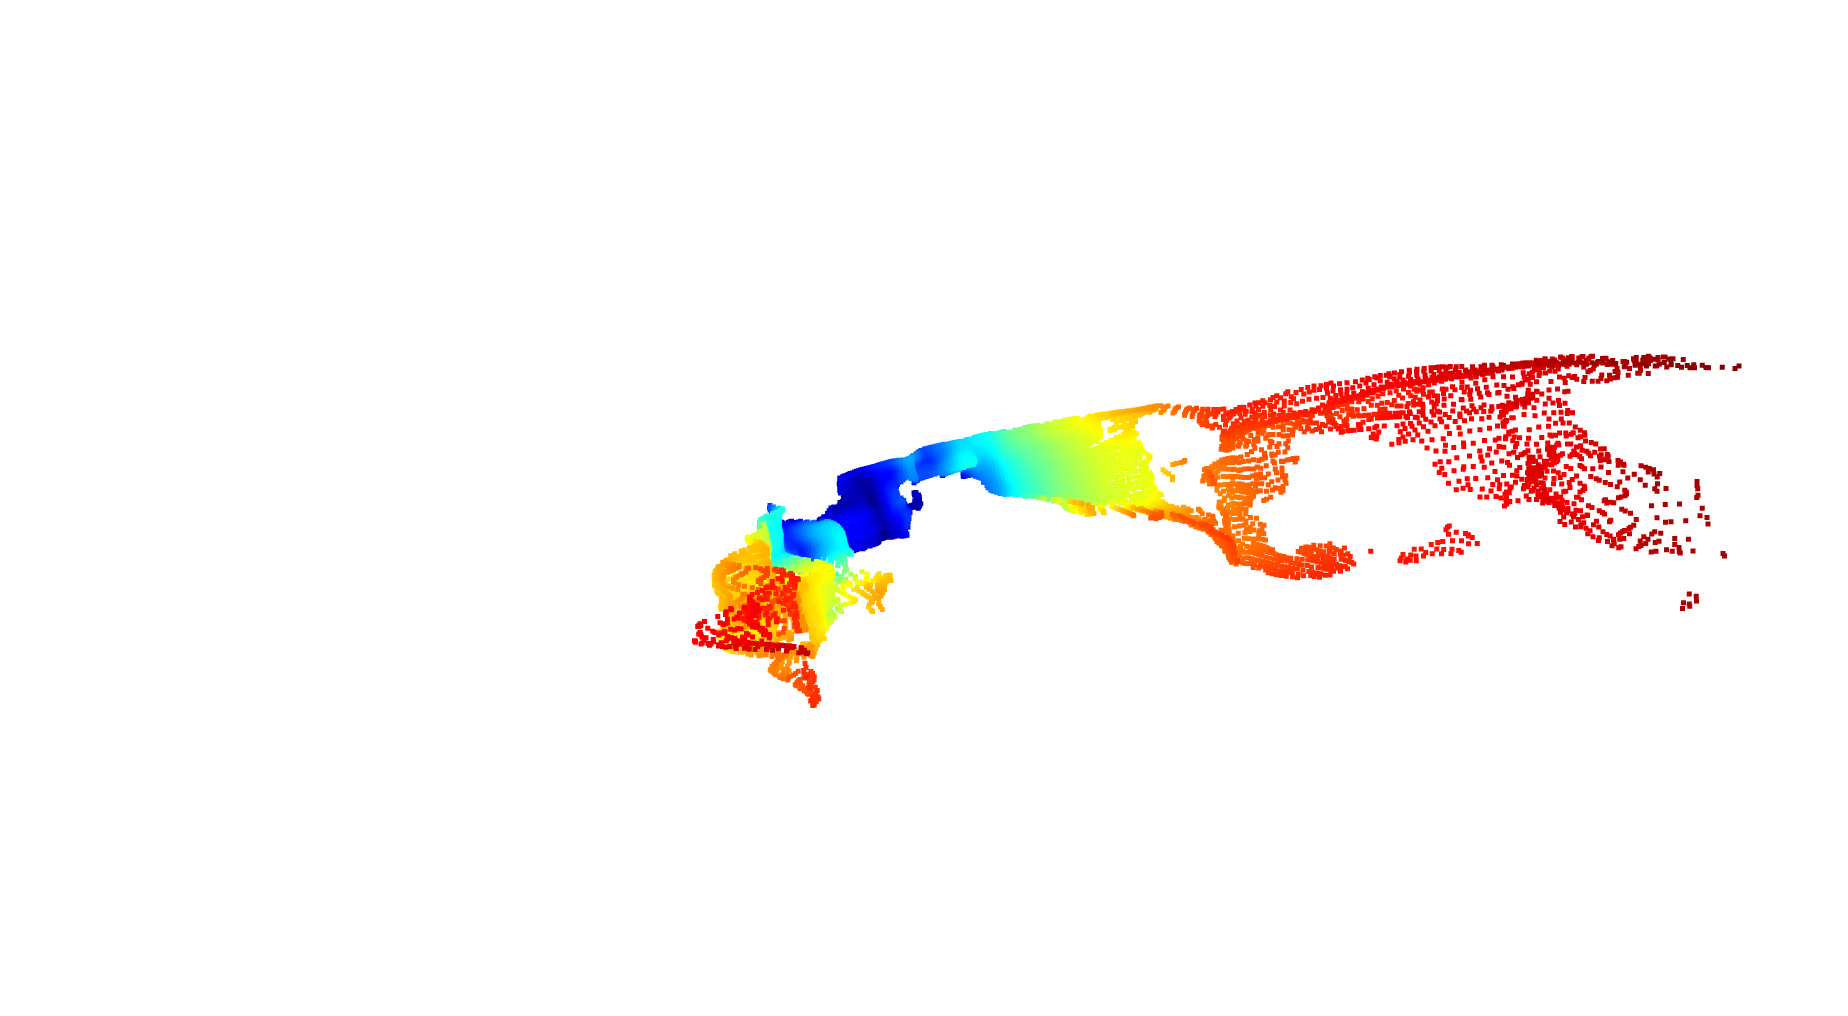

In [313]:
o3d.visualization.draw_geometries([downsm], zoom=0.35)

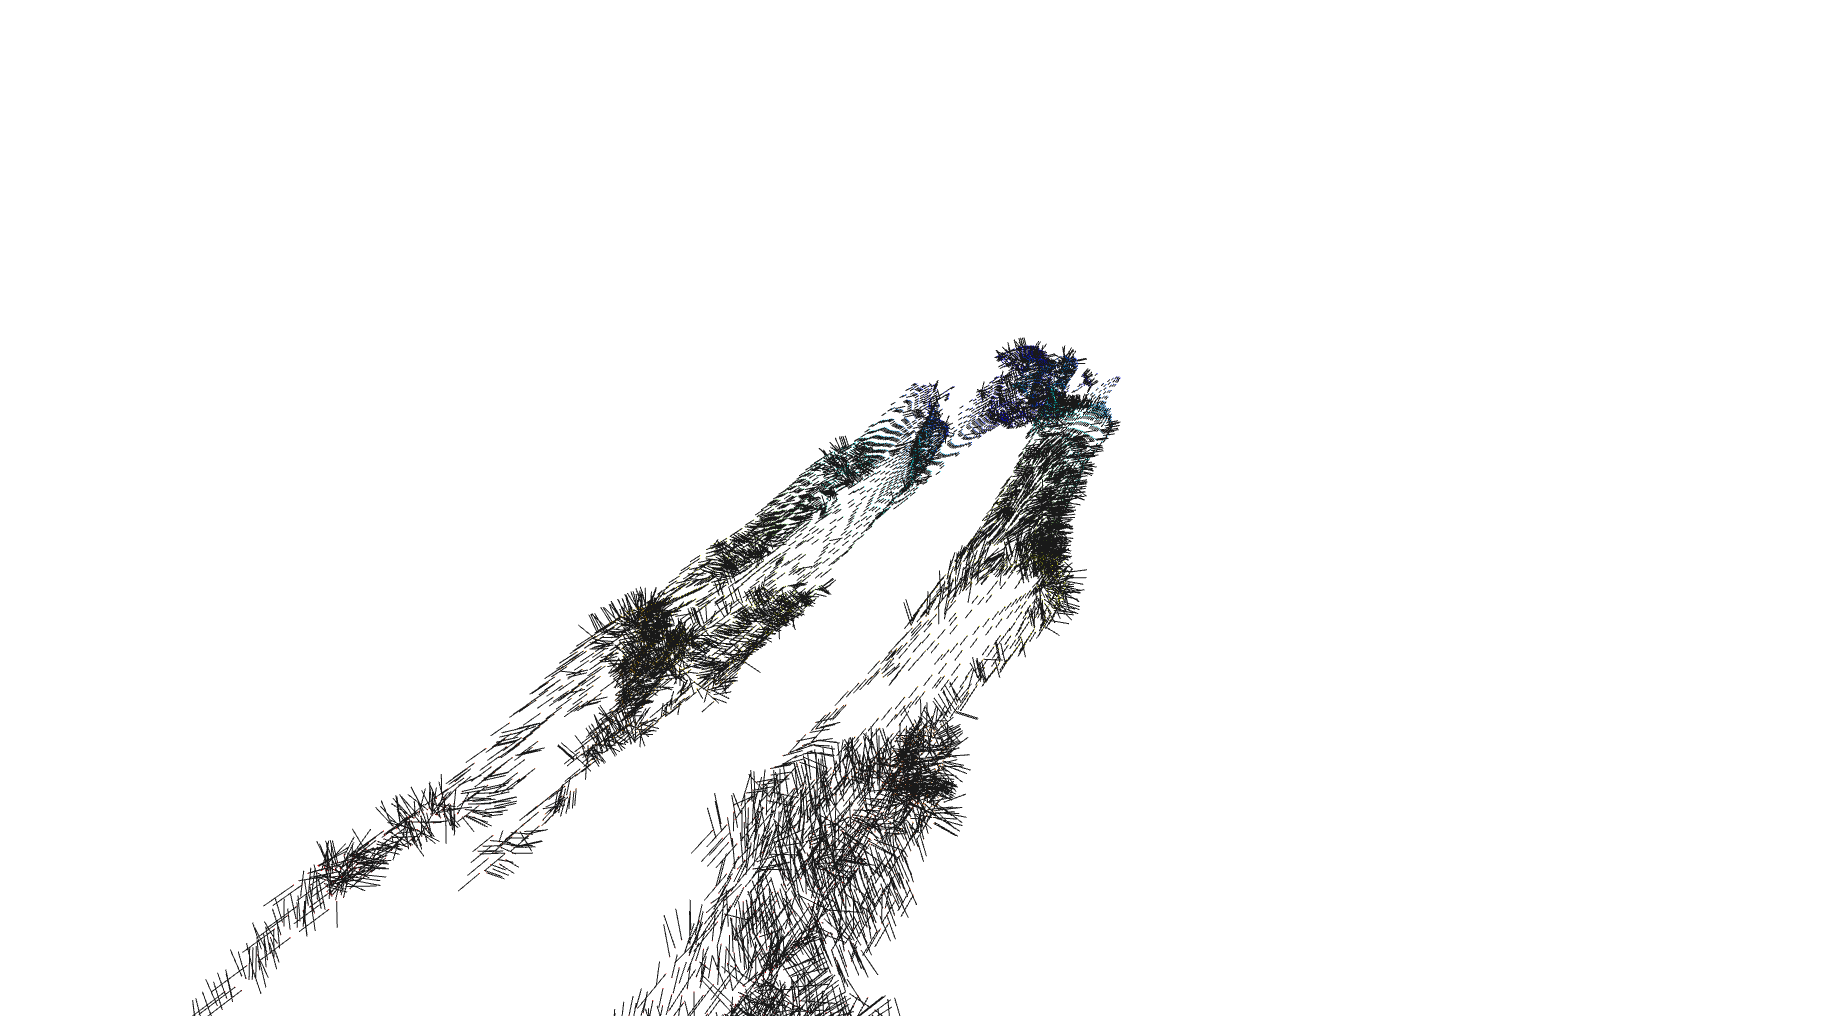

In [314]:
downsm.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.2, max_nn=30))
o3d.visualization.draw_geometries([downsm], zoom=0.35)

In [283]:
np.median(np.asarray(downsm.normals), axis=0)

array([ 0.74084498, -0.09352598,  0.27122695])

In [284]:
0.02 * 0.9 - 0.16 - 0.0042

-0.14620000000000002

Plane equation: 0.07x + 1.00y + -0.02z + -0.44 = 0


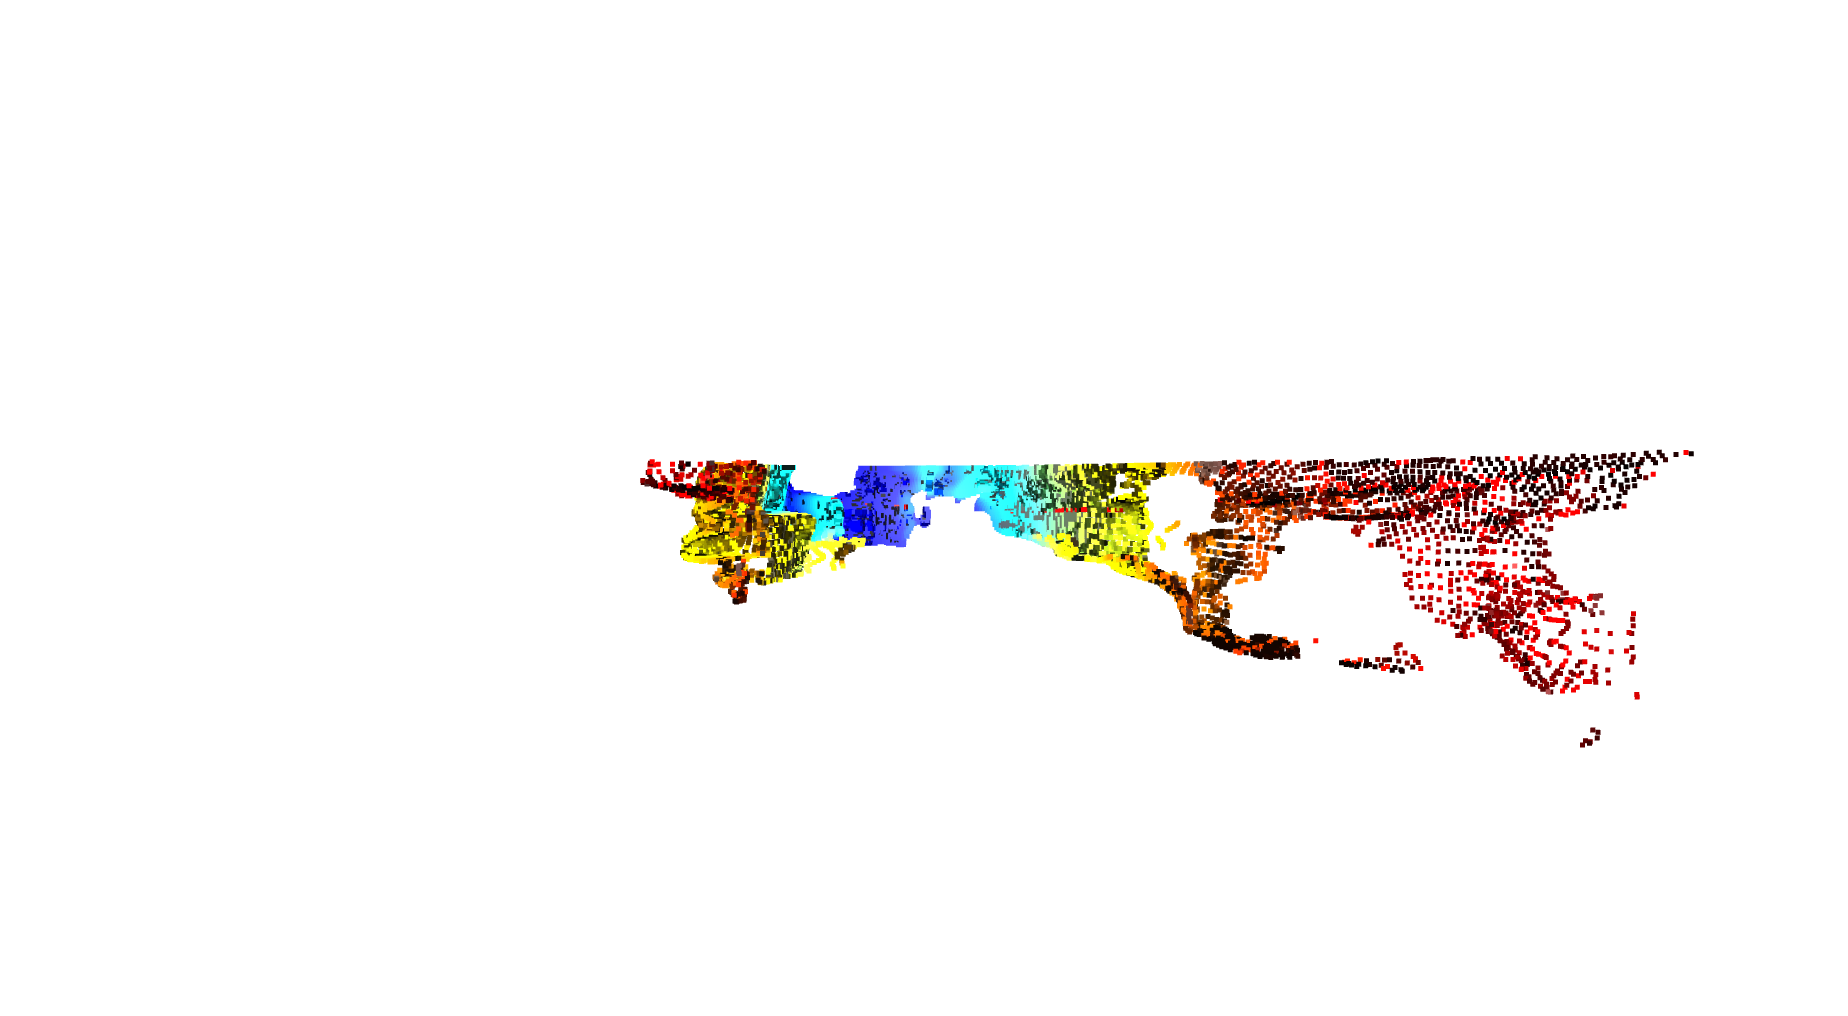

In [315]:
plane_model, inliers = downsm.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=100)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = downsm.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = downsm.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.35)
# Plane equation: 0.90x + -0.16y + 0.42z + 6.26 = 0


Plane equation: 0.03x + 1.00y + -0.00z + -0.19 = 0


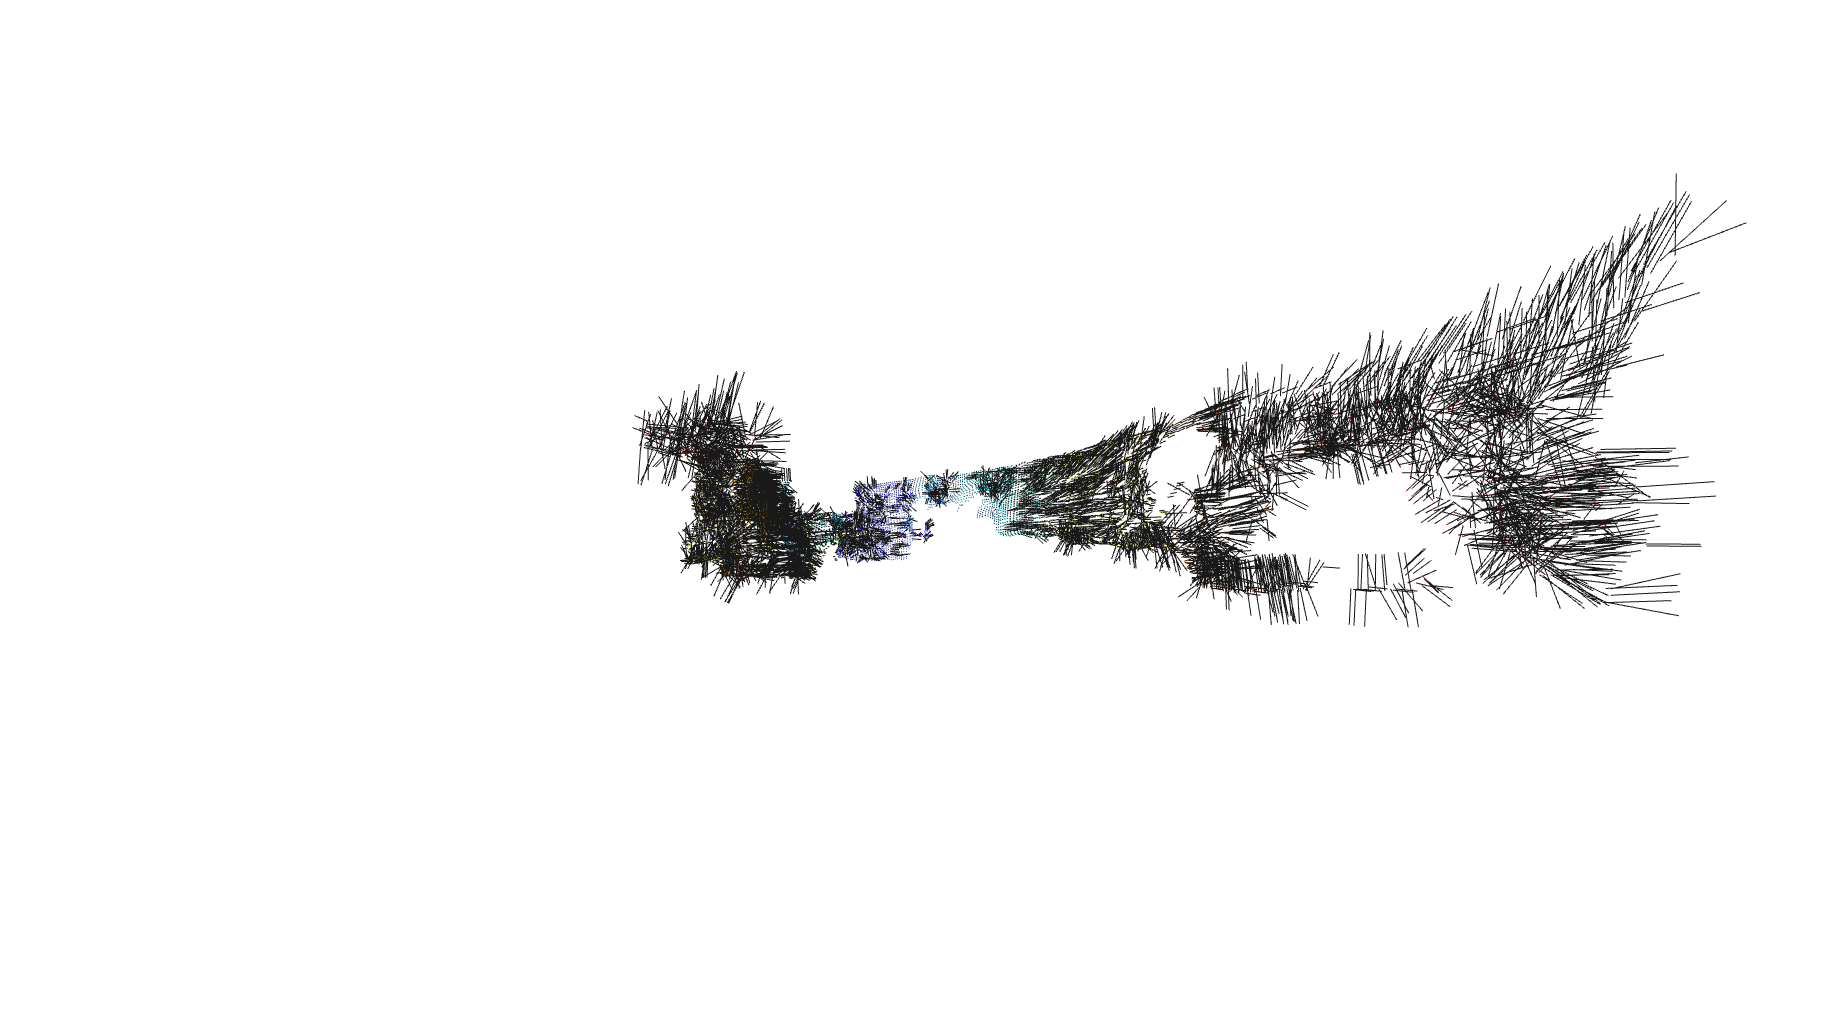

In [316]:
plane_model, inliers = downsm.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=100)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud1 = downsm.select_by_index(inliers)
inlier_cloud1.paint_uniform_color([1.0, 0, 0])
outlier_cloud1 = downsm.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud, inlier_cloud1, outlier_cloud1],
                                  zoom=0.35)

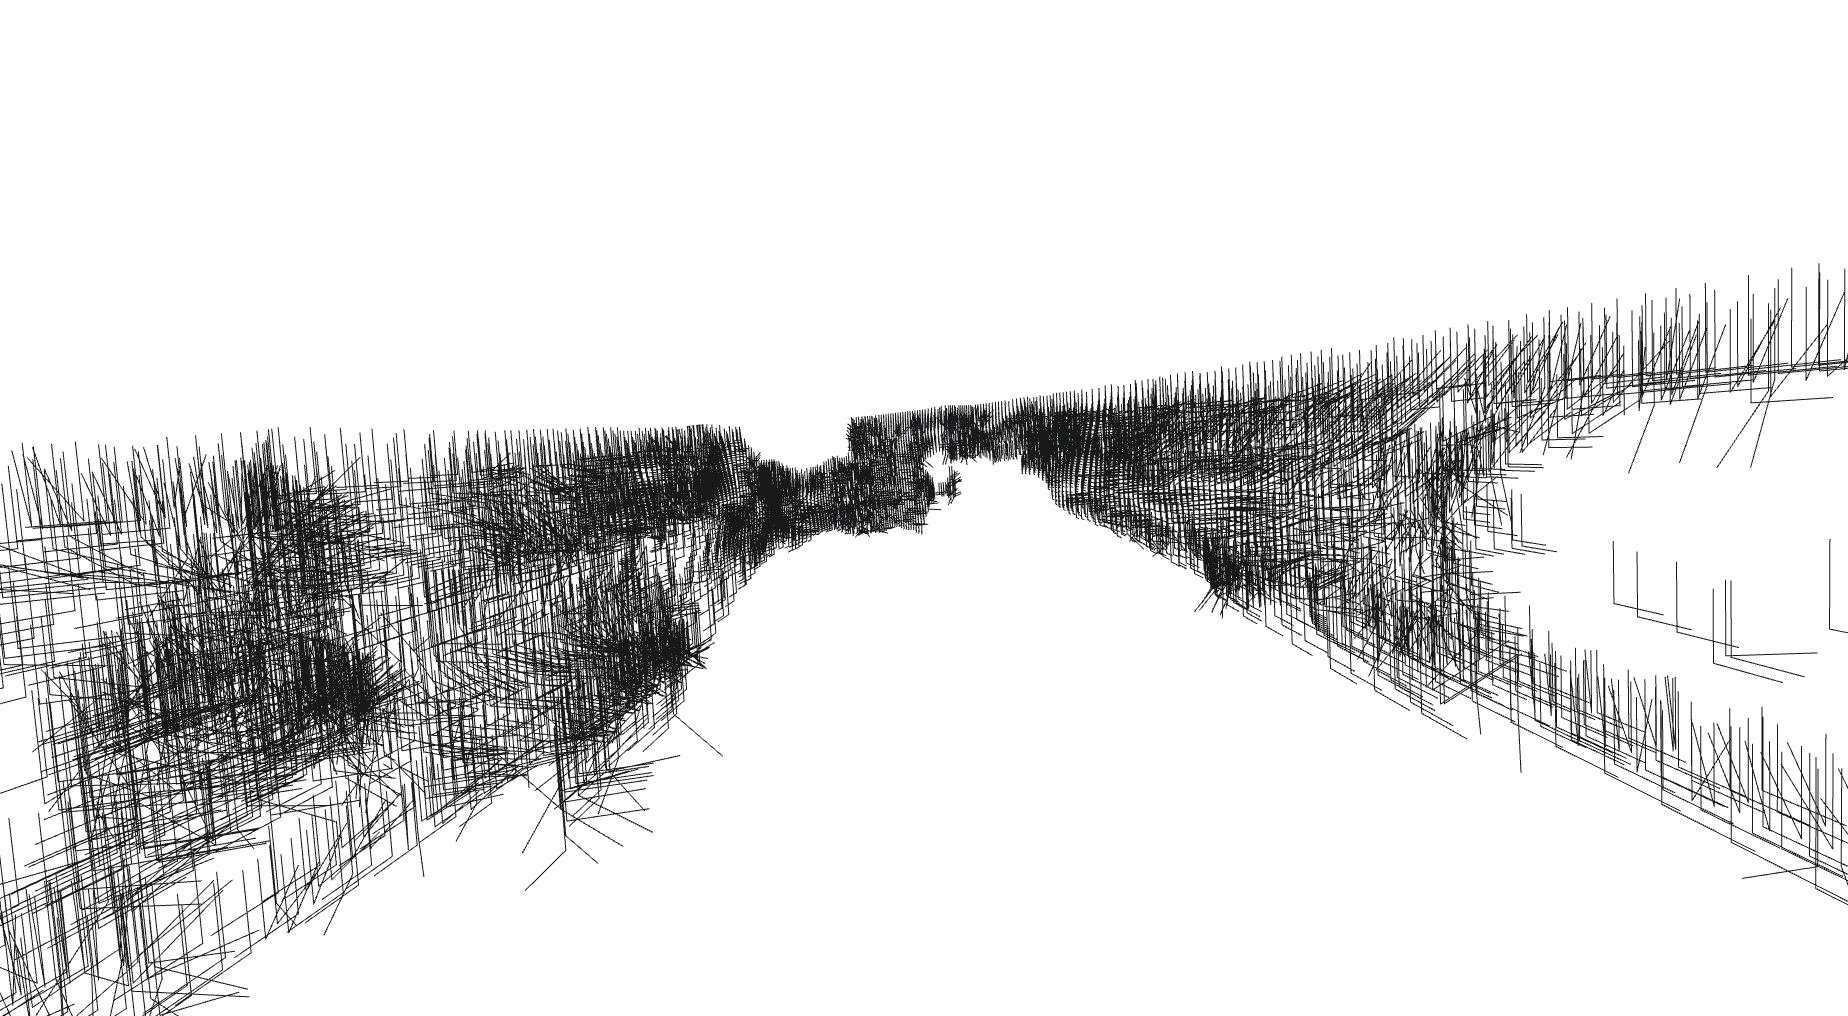

In [317]:
downsm.normals = o3d.utility.Vector3dVector(np.array([np.array([a, b, c]) for _ in range(np.asarray(downsm.normals).shape[0])]))

inlier_cloud1 = downsm.select_by_index(inliers)
inlier_cloud1.paint_uniform_color([1.0, 0, 0])
outlier_cloud1 = downsm.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud, inlier_cloud1, outlier_cloud1],
                                  zoom=0.35)

In [235]:
def filter_depth(depth_map):
    result = depth_map.copy()
    ls = np.asarray(depth_map).flatten()
    arr = [item for item in ls if item > 0]
    q1, q3 = np.quantile(arr, .25), np.quantile(arr, .75)
    x, y = depth_map.shape
    for i in range(x):
        for j in range(y):
            result[i][j] *= q1 <= result[i][j] <= q3
    return result

In [8]:
%%time
from utils import take_topk_segments


take_topk_segments(seg_map, classes={0, 1, 2})

CPU times: user 308 ms, sys: 0 ns, total: 308 ms
Wall time: 314 ms


[(2,
  array([[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])),
 (0,
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]])),
 (1,
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         

In [29]:
import concurrent.futures


def take_topk_segments1(seg_map: np.ndarray, classes = None, k=3, n_workers=8):
    """
        Method selects only top k segments from seg_map.
        If classes is None, then selected from all classes,
        else only from classes in set.
    :param seg_map: segmentation map of image
    :param classes: interested labels
    :param k: number of top segments
    :param n_workers: number of workers for multithreading
    :return: list of maps for every label sorted by popularity
    """
    if classes is not None:
        vect_func = np.vectorize(lambda x: x in classes)
        map_arr = vect_func(seg_map)
        tmp_arr = map_arr * seg_map
    else:
        tmp_arr = seg_map.copy()

    labels = [i for i, _ in Counter(tmp_arr.flatten()).most_common(k)]

    result = []
    # def _inner_func(arr, label):
    #     vect_func = np.vectorize(lambda x: x == label)
    #     return label, vect_func(arr)

    for label in labels:
        vect_func = np.vectorize(lambda x: x == label)
        result.append((label, vect_func(tmp_arr)))
    #
    # with concurrent.futures.ProcessPoolExecutor(max_workers=n_workers) as executor:
    #     arr = executor.map(_inner_func, [(seg_map, label) for label in labels])
    return result

In [30]:
tt = take_topk_segments1(seg_map)

In [31]:
tt

[(2,
  array([[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])),
 (0,
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]])),
 (4,
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ...,  True,  True,  True],
         